In [61]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [62]:
def f(x):
    return 5*x**2 + 2*x + 3

In [63]:
f(5)

138

In [64]:
xs = np.arange(-10,10,step=0.5)
ys = f(xs)

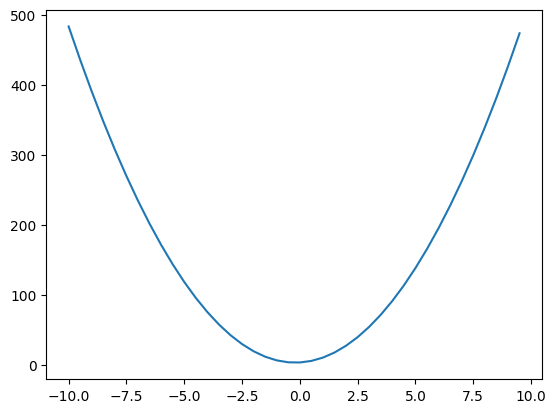

In [65]:
plt.plot(xs,ys)

In [66]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data= data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        return f'Value({self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += out.grad*1
            other.grad += out.grad*1
        out._backward = _backward

        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
        out = self+(-other)
        return out
    
    # def __rsub__(self,other):
    #     return self + (-other)

    def __rmul__(self, other):
        return self * other
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')

        def _backward():
            self.grad += out.grad * (1 / other.data)
            other.grad += out.grad * (-self.data / (other.data ** 2))

        out._backward = _backward
        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self, ),label='tanh', _op="tanh")

        def _backward():
            self.grad += out.grad * (1-t**2)
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

    
a = Value(2, label='a')
b = Value(5, label='b')
c = Value(8, label='c')
e = a*b; e.label='e'
d = e + c ; d.label = 'd'
f = Value(3, label='f')
L = d*f; L.label='L'

In [67]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{%s | data %.4f | %.4f}"% (n.label, n.data, n.grad ),
            shape='record'
        )

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


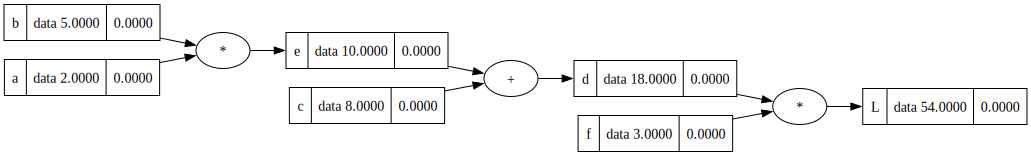

In [68]:
draw_dot(L)

# Chain Rule
L = d*f

dL/dd = f

dL/df = d

d = e + c

dd/dc = 1

dL/dc = dL/dd * dd/dc

dL/dc = f*1

In [69]:
L.grad = 1
f.grad = d.data
d.grad = f.data

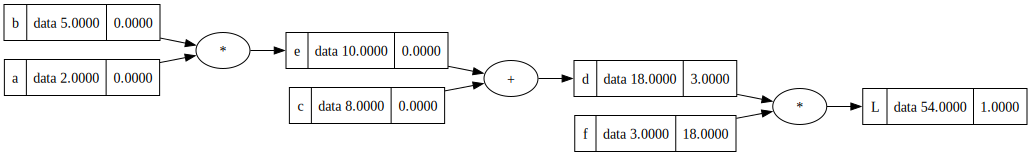

In [70]:
draw_dot(L)

In [71]:
e.grad = d.grad*1
c.grad = d.grad*1

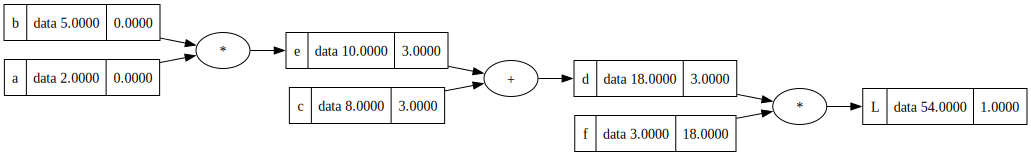

In [72]:
draw_dot(L)

In [73]:
a.grad = b.data*e.grad
b.grad = a.data*e.grad

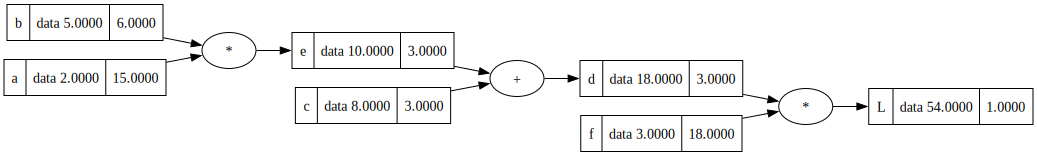

In [74]:
draw_dot(L)

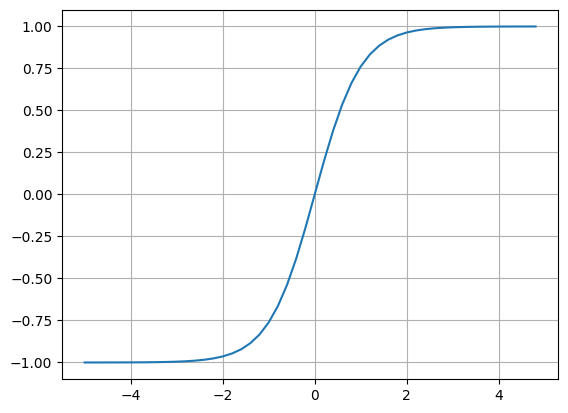

In [75]:
plt.plot(np.arange(-5,5,step=0.2), np.tanh(np.arange(-5,5,step=0.2))); plt.grid()

In [76]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.7,label='b')
x1w1 = x1*w1; x1w1.label='x1 * w1'
x2w2 = x2*w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'

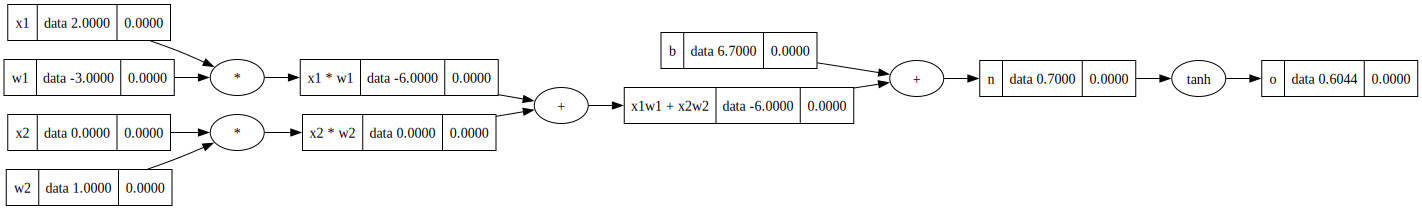

In [77]:
draw_dot(o)

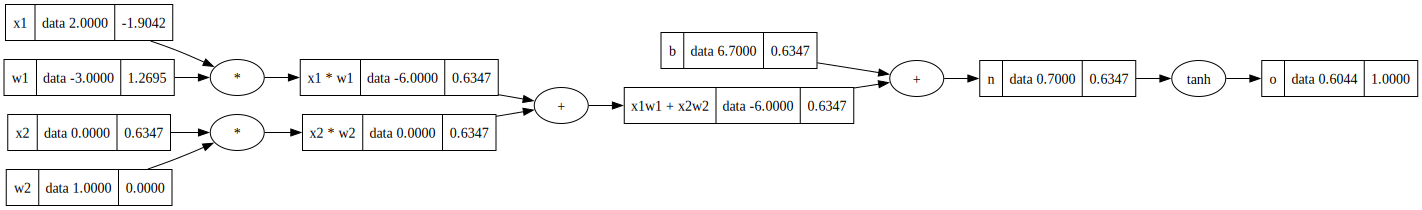

In [78]:
o.backward()
draw_dot(o)

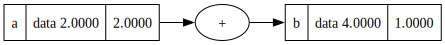

In [79]:
a = Value(2, label='a')
b = a + a;  b.label='b'
b.backward()
draw_dot(b)

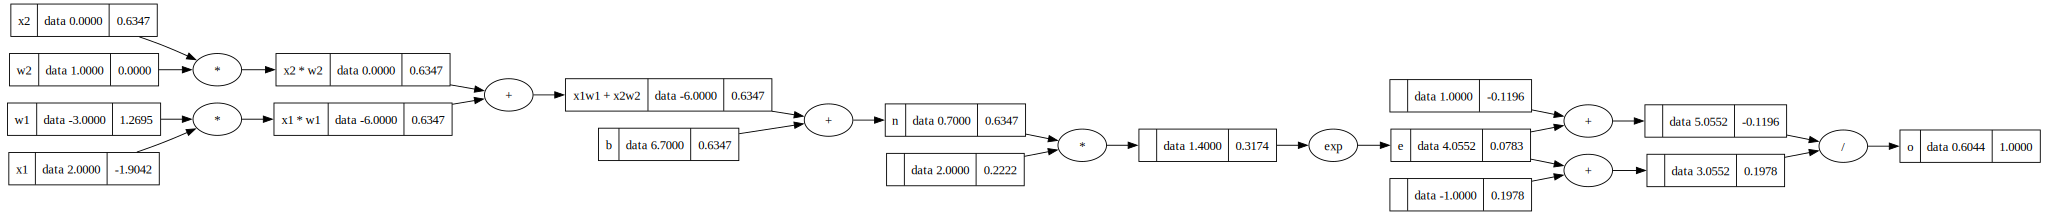

In [80]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.7,label='b')
x1w1 = x1*w1; x1w1.label='x1 * w1'
x2w2 = x2*w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label='n'
e = (n*2).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()

draw_dot(o)

In [81]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad =True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.7]).double(); b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----------------------------------")
print('x2: ', x2.grad.item())
print('x1: ', x1.grad.item())
print('w2: ', w2.grad.item())
print('w1: ', w1.grad.item())

0.6043676560501806
----------------------------------
x2:  0.6347397363204106
x1:  -1.9042192089612318
w2:  0.0
w1:  1.2694794726408212


In [82]:
import random
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self,nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0,3.0, 5.0]
o = [4,4,1]
n = MLP(3,o)
out = n(x)

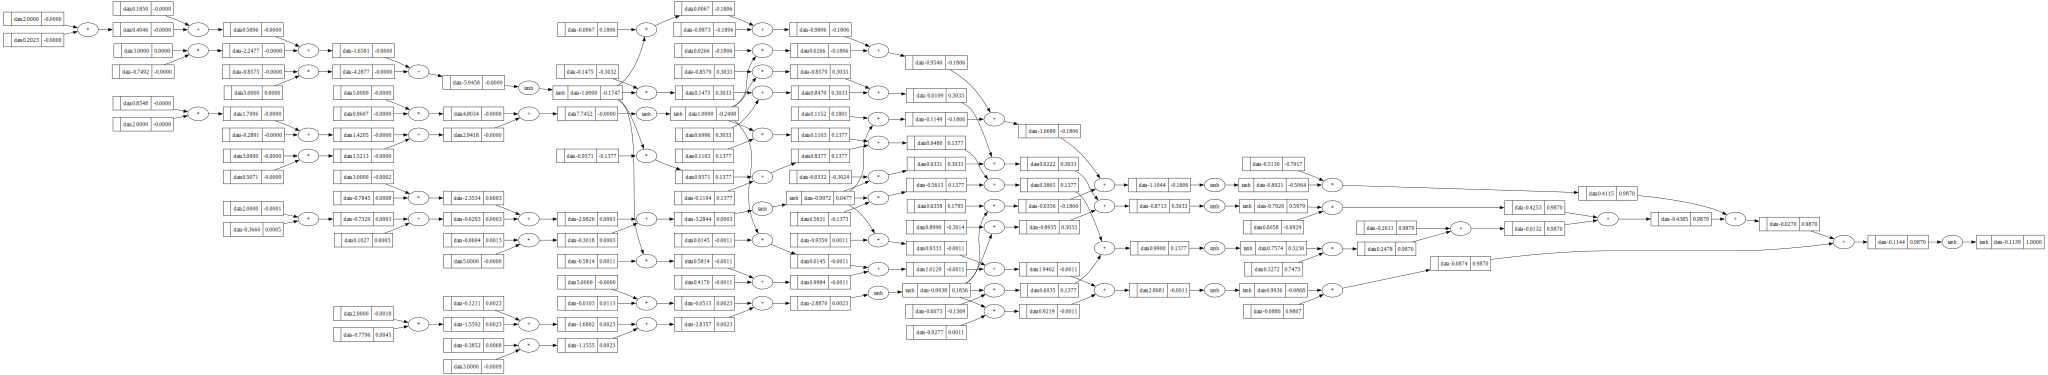

In [83]:
out.backward()
draw_dot(out)

In [84]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0,-1.0,-1.0,1.0]

ypred = [n(x) for x in xs]
ypred

[Value(-0.1742213479799951),
 Value(-0.48301720884013993),
 Value(-0.038139890055695326),
 Value(-0.19155570993768925)]

In [87]:
loss = sum(
    ((Value(ygt) - yout) ** 2 for ygt, yout in zip(ys, ypred)),
    Value(0.0)
)
loss

Value(3.991046861394577)

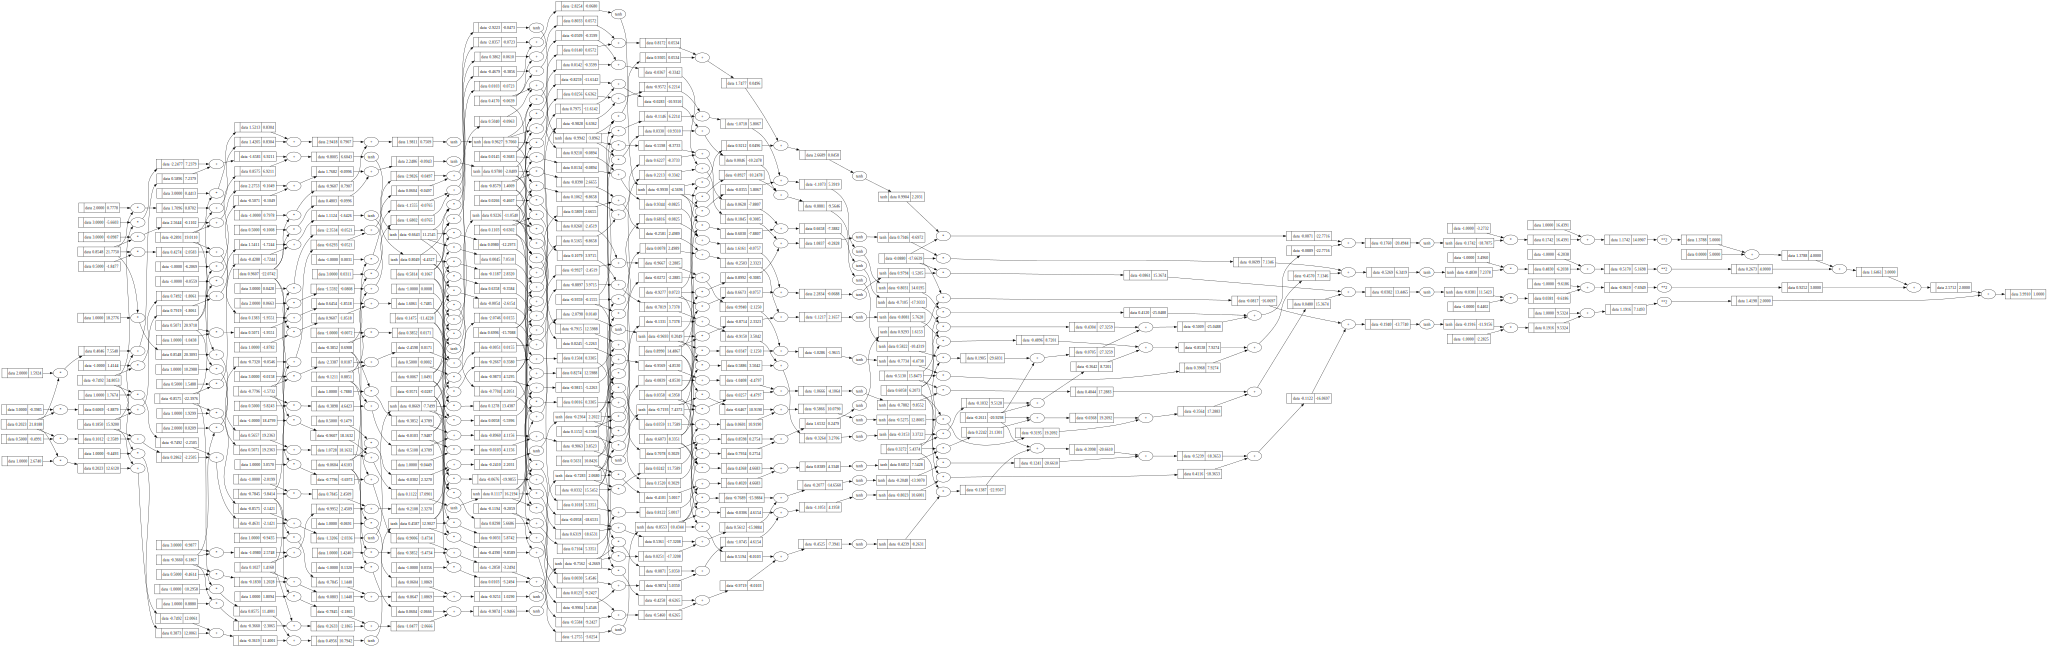

In [89]:
loss.backward()
draw_dot(loss)